In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

# statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# sktime：予測
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# sktime：予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データの変換
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

# sktime：パイプライン
from sktime.forecasting.compose import TransformedTargetForecaster, MultiplexForecaster
from sktime.pipeline import make_pipeline
from sktime.transformations.compose import OptionalPassthrough

# 機械学習法
import lightgbm as lgb

# 再帰的に回帰分析を実行するための関数の読み込み
from sktime.forecasting.compose import make_reduction

# 周期性やトレンドの関する特徴量を作成
from statsmodels.tsa.deterministic import DeterministicProcess

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

# Warningを出力させないようにする
import warnings

warnings.filterwarnings("ignore")

In [3]:
# オオヤマネコデータの読み込み
lynx = sm.datasets.get_rdataset("lynx").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1821-01", periods=len(lynx), freq="Y")
lynx.index = date_index

# 不要な時間ラベルの削除
lynx = lynx.drop(lynx.columns[0], axis=1)

# 結果の確認
print(lynx.head(10))

      value
1821    269
1822    321
1823    585
1824    871
1825   1475
1826   2821
1827   3928
1828   5943
1829   4950
1830   2577


In [4]:
# 参考：データの年数
len(lynx)

114

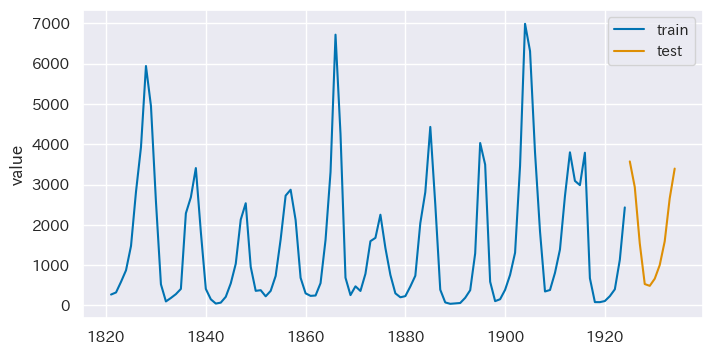

In [5]:
# 訓練データとテストデータに分割する
train_lynx, test_lynx = temporal_train_test_split(lynx, test_size=10)

# 折れ線グラフを描く
fig, ax = plot_series(
    train_lynx, test_lynx, labels=["train", "test"], markers=np.tile("", 2)
)

# グラフサイズの指定
fig.set_size_inches(8, 4)

In [6]:
# 予測期間
fh_lynx = np.arange(1, len(test_lynx) + 1)
fh_lynx

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [7]:
# ============================================================
# ラグデータ（過去データの遅れ変数）を作成する処理
# ============================================================

# ------------------------------------------------------------
# ラグの設定
# ------------------------------------------------------------
# 「lag = 10」は、現在時点 t の値を予測する際に
# 「過去10時点分のデータ（t-1 ~ t-10）」を説明変数として使うという意味。
# これは自己回帰モデル（ARモデル）やニューラルネットなどで
# 時系列の依存構造を捉えるための一般的な特徴量設計である。
lag = 10

# ------------------------------------------------------------
# lagmat関数によるラグ行列の生成
# ------------------------------------------------------------
# statsmodels.tsa.api.lagmat() は、与えられた系列から「ラグ行列（遅れ変数行列）」を生成する。
# 各行は1時点分の観測データを表し、列には t-1, t-2, ..., t-10 の値が順に並ぶ。
#
# 引数の意味：
# - train_lynx : 対象の時系列データ（例：カナダのオオヤマネコの捕獲数）
# - maxlag=lag : 作成する最大ラグの数
# - original='ex' : 元の系列を除外し、ラグのみを含む（＝説明変数行列）
# - trim='both' : ラグが計算できない先頭および末尾の行を削除
# - use_pandas=True : pandas.DataFrame形式で出力
#
# この処理により、自己回帰モデル（ARモデル）を OLS で推定するための
# デザイン行列（説明変数行列）が得られる。
lynx_lag = tsa.lagmat(
    train_lynx,
    maxlag=lag,  # ラグ数10
    original="ex",  # 元系列は除外（説明変数としてラグのみを使用）
    trim="both",  # 欠損の出る前後を削除
    use_pandas=True,  # pandasで返す
)

# ------------------------------------------------------------
# 結果の確認
# ------------------------------------------------------------
# 生成されたラグ行列の上位3行を出力。
# 各列は t-1, t-2, ..., t-10 の値を表している。
print(lynx_lag.head(3))

      value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1831     2577.0     4950.0     5943.0     3928.0     2821.0     1475.0   
1832      523.0     2577.0     4950.0     5943.0     3928.0     2821.0   
1833       98.0      523.0     2577.0     4950.0     5943.0     3928.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1831      871.0      585.0      321.0       269.0  
1832     1475.0      871.0      585.0       321.0  
1833     2821.0     1475.0      871.0       585.0  


In [8]:
# 結果の確認
print(train_lynx["1831":"1841"])

      value
1831    523
1832     98
1833    184
1834    279
1835    409
1836   2285
1837   2685
1838   3409
1839   1824
1840    409
1841    151


In [9]:
# LightGBMのハイパーパラメータを設定
params = {
    "objective": "regression",  # 回帰を目的とする
    "seed": 1,  # 乱数の種
    "num_leaves": 20,  # 葉の数の最大値
    "learning_rate": 0.05,  # 学習率
    "n_estimators": 100,  # ブースティングの回数
    "min_data_in_leaf": 1,  # 1つの葉における最小データ数
    "verbose": -1,  # ワーニングなどの非表示
}

In [10]:
# モデル化
gbm = lgb.LGBMRegressor(**params)

# モデルの当てはめ
gbm.fit(lynx_lag, train_lynx.loc["1831":])

LGBMRegressor(learning_rate=0.05, min_data_in_leaf=1, num_leaves=20,
              objective='regression', seed=1, verbose=-1)

In [11]:
# テストデータの最初の値
print(test_lynx.head(1))

      value
1925   3574


In [12]:
# ラグデータの作成
lynx_lag_all = tsa.lagmat(lynx, maxlag=lag, original="ex", trim="both", use_pandas=True)

# 結果の確認
print(lynx_lag_all.loc["1925":"1925"])

      value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1925     2432.0     1132.0      399.0      229.0      108.0       80.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1925       81.0      674.0     3790.0      2985.0  


In [13]:
# testデータの最初の1年目を予測
gbm.predict(lynx_lag_all.loc["1925":"1925"])

array([2281.66646241])

In [14]:
# 2時点先予測に使う説明変数
x_target = lynx_lag_all.loc["1925":"1925"].copy()
x_target.iloc[:, 1:] = x_target.iloc[:, 0:9]
x_target.iloc[:, 0] = gbm.predict(lynx_lag_all.loc["1925":"1925"])[0]
print(x_target)

        value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1925  2281.666462     2432.0     1132.0      399.0      229.0      108.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1925       80.0       81.0      674.0      3790.0  


In [15]:
# 2時点先の予測
gbm.predict(x_target)

array([861.15379196])